# Introduction
---
In this assignment, we will try to find the best model for a given dataset.
We will perform the following stages:
1. Import the data
2. Preliminary data analysis
3. Preprocessing
4. Trying different models
5. Training on modified data
6. Optuna for the best hyperparameters

We will choose between the following classification models __learned in class so far__:
- KNN
- linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree
- Random Forest
- AdaBoost
- Gradient Boosting
- XGBoost
- SVM

In [99]:
import pickle
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import KFold
from tqdm import tqdm
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import optuna

# 1. Import the Data set
---

In [73]:
## Load the data
with open('../../data/ass3.pickle', 'rb') as f:
    data = pickle.load(f)

In [74]:
## Example of train samples
df = pd.DataFrame(data['train'])
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,target
14981,4.0391,15.0,6.297710,0.992366,334.0,2.549618,32.72,-116.99,1.695
6614,4.7241,46.0,5.375758,0.954545,753.0,2.281818,34.17,-118.10,2.796
14233,3.3553,7.0,5.229213,1.101124,1304.0,2.930337,32.70,-117.01,1.322
1802,1.3929,52.0,5.000000,0.953488,126.0,2.930233,37.92,-122.36,1.042
6030,1.6006,52.0,4.427083,1.017361,1246.0,2.163194,34.07,-117.75,1.462


#### Extract train, dev, test datasets (x and y)

In [75]:
## Get train dev test Xs and ys (X type is dataFrame and y type is Series)
df_train = data['train']
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

df_dev = data['dev']
X_dev = df_dev.iloc[:, :-1]
y_dev = df_dev.iloc[:, -1]

df_test = data['test']
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# 2. Preliminary data analysis
---
In this section, we will analyze the data and try to understand it better.
We will focus on the following:
- What is the problem type? (classification/regression)
- What is the data distribution?
- What is the data range?
- Are there missing values?
- What is the correlation between the features?
- What is the correlation between each feature and the label?
- What is the distribution of each feature?

In [76]:
print(f"X_train shape: {X_train.shape}")
print(f"X_dev shape: {X_dev.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (12384, 8)
X_dev shape: (4128, 8)
X_test shape: (4128, 8)


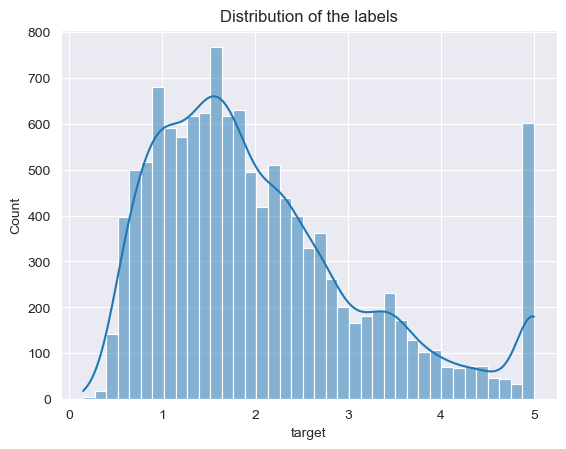

In [77]:
sns.histplot(y_train, kde=True)
plt.title('Distribution of the labels')
plt.show()

##### We can see that the train labels are distributed normally, with an anomaly at the end.

## Missing values

In [78]:
print(f"Number of missing values in train: {X_train.isnull().sum().sum()}")

Number of missing values in train: 1238


In [79]:
# where are the missing values?
X_train.isnull().sum()

f0    174
f1    140
f2    158
f3    156
f4    169
f5    142
f6    151
f7    148
dtype: int64

In [80]:
# check in which examples the missing values are
X_train[X_train.isnull().any(axis=1)]


,f0,f1,f2,f3,f4,f5,f6,f7
19195,3.4545,36.0,4.891791,0.966418,648.0,2.417910,38.44,NaN
4231,NaN,52.0,5.174917,1.113861,1213.0,2.001650,34.11,-118.30
19943,1.9355,10.0,5.136555,1.105042,1262.0,2.651261,NaN,-119.36
18650,NaN,37.0,6.572748,1.277136,939.0,2.168591,36.88,-121.96
526,3.0161,52.0,4.673721,0.998236,NaN,2.589065,37.77,-122.25
...,...,...,...,...,...,...,...,...
3099,3.3269,15.0,NaN,1.122807,1245.0,2.426901,35.65,-117.68
13194,3.2344,14.0,5.248731,1.124365,2026.0,2.571066,34.08,NaN
9283,5.6150,27.0,6.678373,NaN,4406.0,2.714726,38.08,-122.58
6951,3.0577,NaN,4.854839,1.016129,1002.0,4.040323,33.99,-118.07


In [81]:
#  check missing values in y_train
y_train.isnull().sum()

0

## Data range and correlation

In [82]:
X_train.describe()

,f0,f1,f2,f3,f4,f5,f6,f7
count,12210.000000,12244.000000,12226.000000,12228.000000,12215.000000,12242.000000,12233.000000,12236.000000
mean,3.872771,28.630595,5.420978,1.096626,1426.830618,3.144714,35.626833,-119.561040
std,1.919183,12.566127,2.382548,0.471398,1103.528284,13.440452,2.133539,1.996646
min,0.499900,1.000000,0.846154,0.500000,3.000000,0.692308,32.550000,-124.350000
25%,2.555600,18.000000,4.430232,1.006386,786.000000,2.428571,33.940000,-121.790000
50%,3.534100,29.000000,5.218429,1.049202,1170.000000,2.816384,34.250000,-118.490000
75%,4.745975,37.000000,6.043349,1.099202,1739.000000,3.276456,37.710000,-118.020000
max,15.000100,52.000000,132.533333,34.066667,28566.000000,1243.333333,41.950000,-114.550000


#### We can also visualize the data range of each feature

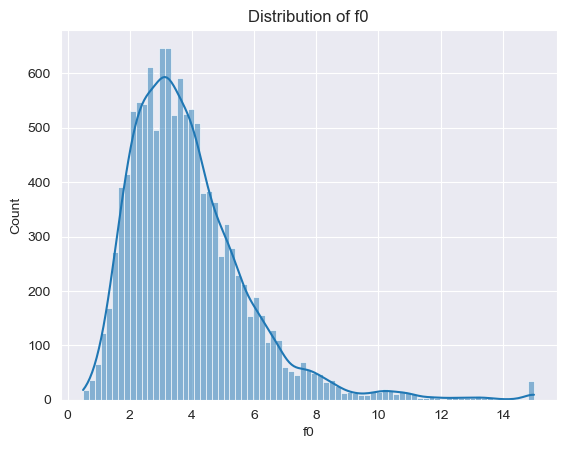

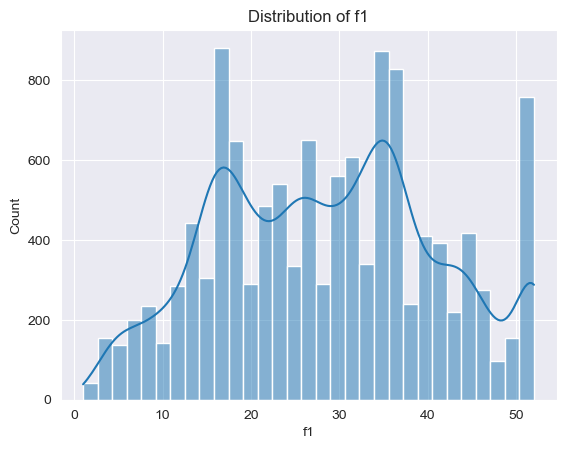

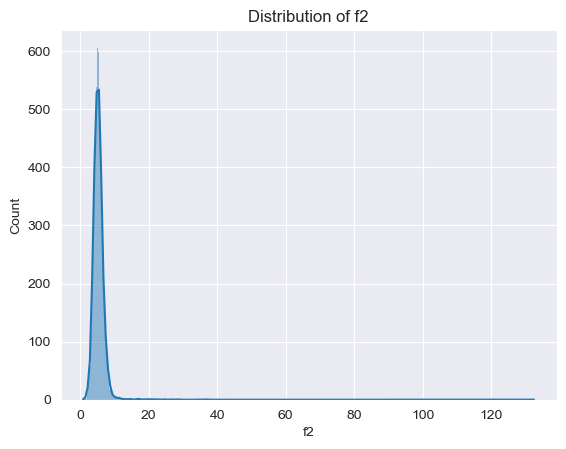

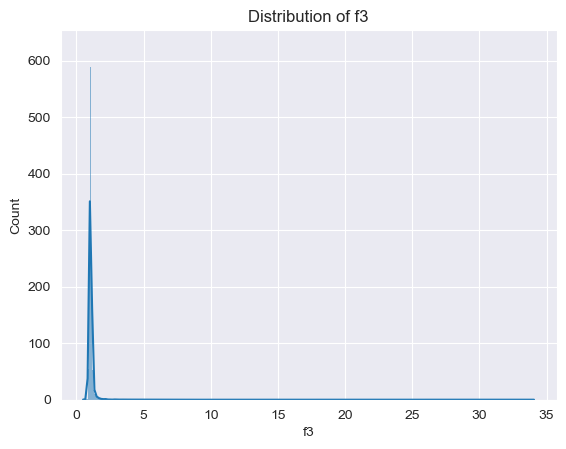

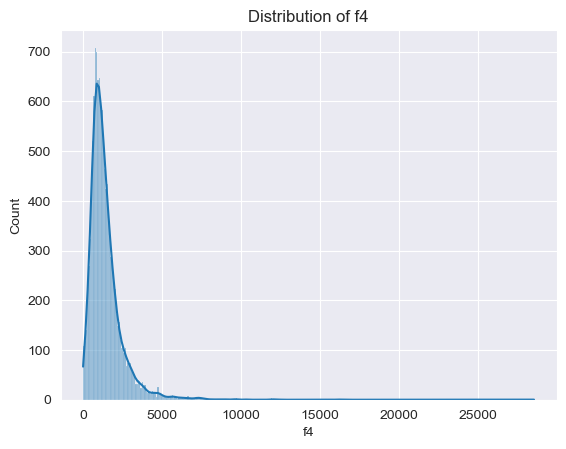

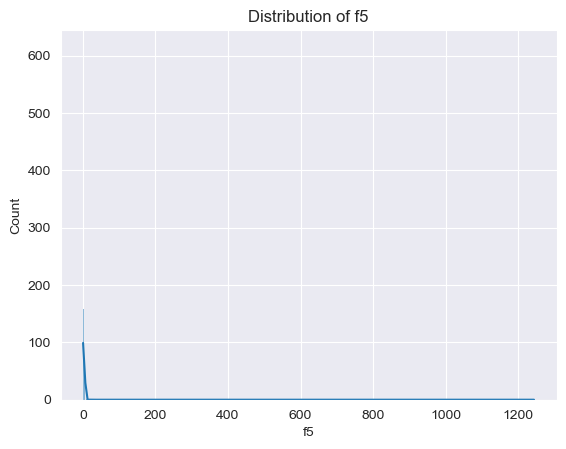

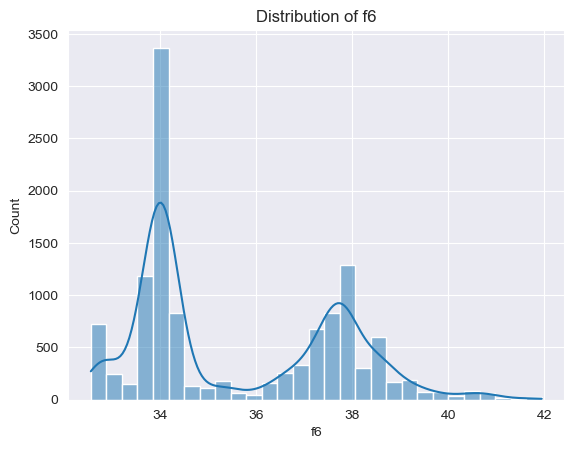

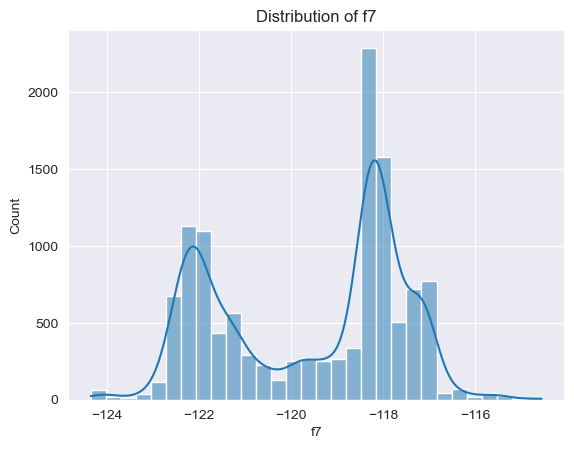

In [83]:
for col in X_train.columns:
    sns.histplot(X_train[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

#### The data range is very different between the features. We will deal with it in the preprocessing section, by scaling all the features to the same range.

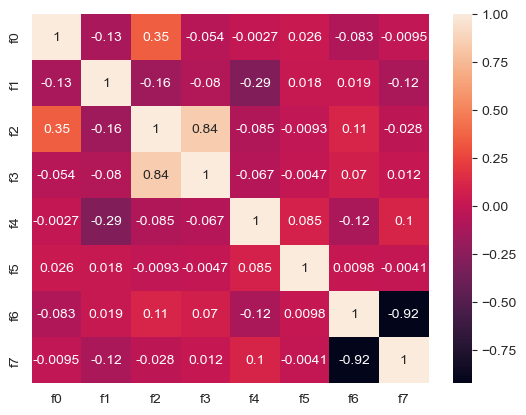

In [84]:
# check the correlation between the features
corr = X_train.corr()
sns.heatmap(corr, annot=True)
plt.show()

#### It looks like there is a positive correlation between f2 and f3 and a negetive correlation between f6 and f7

In [85]:
def plot_feature_label_correlation(X: pd.DataFrame, y: pd.Series):
    # show correlation between each feature and the label
    all_correlations = []
    for col in X.columns:
        corr = X[col].corr(y)
        all_correlations.append(corr)
    # plot the correlation between each feature and the label
    plt.figure(figsize=(20, 10))

    # add title and labels
    plt.title('Correlation between each feature and the label')
    plt.xlabel('Features')
    plt.ylabel('Correlation')
    # plot the barplot
    sns.barplot(x=X.columns, y=all_correlations)
    return all_correlations

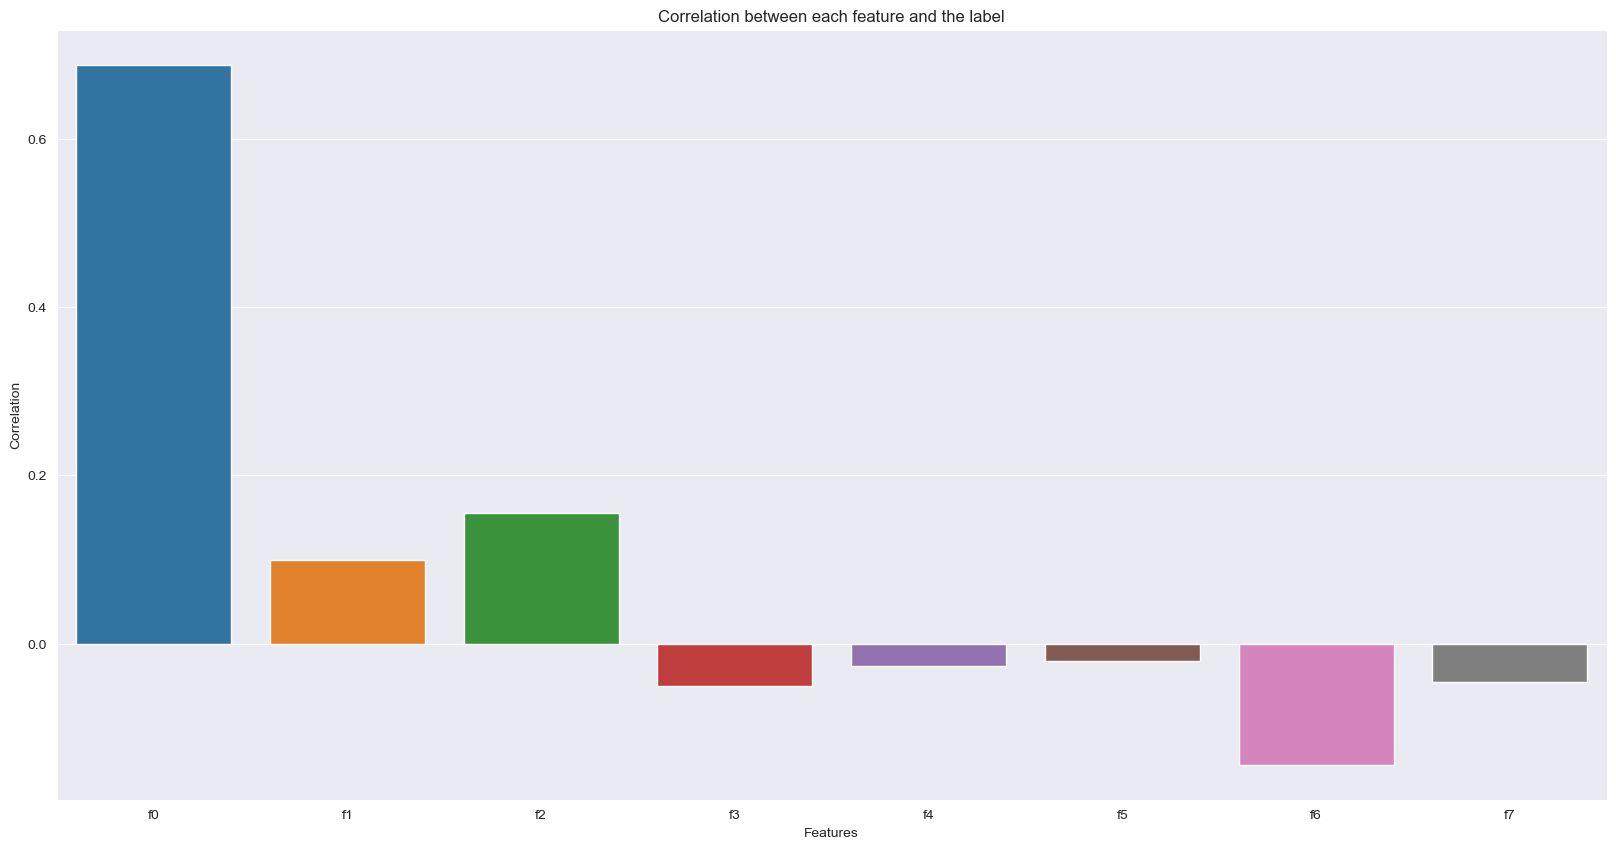

In [86]:
all_correlations = plot_feature_label_correlation(X_train, y_train)

##### All the features correlation with the label is relatively low, but we can see that f0 has the highest correlation. We might consider adding a weight to it in the preprocessing section.

# 3. Preprocessing
---
In this section, we will preprocess the data in order to improve the model's performance.
We will do the following:
- Concatenate train and dev sets to use KFold cross validation
- Fill missing values with the mean of the feature
- Scale the features to the same range
- Give f0 a higher weight

In [87]:
# create trainDev set by combining train and dev
X_train_dev = pd.concat([X_train, X_dev])
y_train_dev = pd.concat([y_train, y_dev])


In [88]:
# add mean of features at missing values
X_train_dev_mean = X_train_dev.fillna(X_train_dev.mean())

In [89]:
# change features mean to 0 and std to 1
X_train_dev_norm = (X_train_dev_mean - X_train_dev_mean.mean()) / X_train_dev_mean.std()
X_train_dev_norm.describe()


,f0,f1,f2,f3,f4,f5,f6,f7
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,5.072385e-17,-1.482449e-16,1.580347e-16,-1.120443e-16,1.176922e-16,-1.939125e-17,2.904277e-15,1.625422e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.785211e+00,-2.199688e+00,-1.951285e+00,-1.654156e+00,-1.293354e+00,-2.074578e-01,-1.449188e+00,-2.404201e+00
25%,-6.875172e-01,-8.451907e-01,-4.164233e-01,-1.930391e-01,-5.770714e-01,-5.751393e-02,-7.948598e-01,-1.112451e+00
50%,-1.690118e-01,-2.830671e-16,-7.864882e-02,-9.961572e-02,-2.253094e-01,-2.377402e-02,-6.395157e-01,5.261111e-01
75%,4.562182e-01,6.686589e-01,2.619232e-01,6.671058e-03,2.688434e-01,1.530254e-02,9.798281e-01,7.774243e-01
max,5.892926e+00,1.863803e+00,5.422501e+01,7.153656e+01,2.473613e+01,1.069275e+02,2.975763e+00,2.551695e+00


In [90]:
# give f0 a higher weight
X_train_dev_f0_weighted = X_train_dev_norm.copy()
X_train_dev_f0_weighted['f0'] = X_train_dev_f0_weighted['f0'] * 100
X_train_dev_f0_weighted.describe()


,f0,f1,f2,f3,f4,f5,f6,f7
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,5.108747e-15,-1.482449e-16,1.580347e-16,-1.120443e-16,1.176922e-16,-1.939125e-17,2.904277e-15,1.625422e-15
std,1.000000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.785211e+02,-2.199688e+00,-1.951285e+00,-1.654156e+00,-1.293354e+00,-2.074578e-01,-1.449188e+00,-2.404201e+00
25%,-6.875172e+01,-8.451907e-01,-4.164233e-01,-1.930391e-01,-5.770714e-01,-5.751393e-02,-7.948598e-01,-1.112451e+00
50%,-1.690118e+01,-2.830671e-16,-7.864882e-02,-9.961572e-02,-2.253094e-01,-2.377402e-02,-6.395157e-01,5.261111e-01
75%,4.562182e+01,6.686589e-01,2.619232e-01,6.671058e-03,2.688434e-01,1.530254e-02,9.798281e-01,7.774243e-01
max,5.892926e+02,1.863803e+00,5.422501e+01,7.153656e+01,2.473613e+01,1.069275e+02,2.975763e+00,2.551695e+00


# 4. Trying different models on the original datasets
---
In this section, we will try different models, without any modifications to the models and compare their performance.


In [91]:
def choose_model_with_k_fold(models_list, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    all_models_scores = []
    for model in tqdm(models_list, desc="Trying models"):
        scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
        score = scores.mean()
        all_models_scores.append(score)
    best_score_idx = np.argmax(all_models_scores)
    # print all models names and scores
    for i in range(len(models_list)):
        print(f"{models_list[i].__class__.__name__}: {all_models_scores[i]}")
    print("=====================================")
    print(f"Best score: {all_models_scores[best_score_idx]}")
    print(f"Best model: {models_list[best_score_idx].__class__.__name__}")
    best_model = models_list[best_score_idx]
    return best_model

In [92]:
models_list = [
    KNeighborsRegressor(),
    LinearRegression(),
    Ridge(),
    Lasso(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    xgb.XGBRegressor(),
    SVR(),
]
best_model = choose_model_with_k_fold(models_list, X_train_dev_mean, y_train_dev)

Trying models: 100%|██████████| 10/10 [03:55<00:00, 23.58s/it]

KNeighborsRegressor: 0.11336079865476553
LinearRegression: 0.5857793312111452
Ridge: 0.5857953269981134
Lasso: 0.2678756333595492
DecisionTreeRegressor: 0.5596190304615863
RandomForestRegressor: 0.7891032889385903
AdaBoostRegressor: 0.48410986148575397
GradientBoostingRegressor: 0.7668738811661175
XGBRegressor: 0.8142069873201411
SVR: -0.028680748743968774
Best score: 0.8142069873201411
Best model: XGBRegressor


#### We can see that XGB boost gets the best score on the original dataset.

# 5. Trying different models on the modified datasets
---
In this section, we will try different models, with the modifications we made in the preprocessing section and compare their performance.
a. The first modification is to scale the features to the same range.
b. The second modification is to give f0 a higher weight.

In [95]:
best_model_normalized = choose_model_with_k_fold(models_list, X_train_dev_norm, y_train_dev)

Trying models: 100%|██████████| 10/10 [03:22<00:00, 20.27s/it]

KNeighborsRegressor: 0.6595211668025447
LinearRegression: 0.5857793312111451
Ridge: 0.5857864152423282
Lasso: -0.0010668856781354207
DecisionTreeRegressor: 0.5550989702385064
RandomForestRegressor: 0.7884317241506873
AdaBoostRegressor: 0.42787279476104595
GradientBoostingRegressor: 0.7668900710825082
XGBRegressor: 0.8143169304678782
SVR: 0.7118450264521943
Best score: 0.8143169304678782
Best model: XGBRegressor


In [96]:
best_model_f0_weighted = choose_model_with_k_fold(models_list, X_train_dev_f0_weighted, y_train_dev)

Trying models: 100%|██████████| 10/10 [03:49<00:00, 22.91s/it]

KNeighborsRegressor: 0.5309743511514166
LinearRegression: 0.5857793312111451
Ridge: 0.5857848625962261
Lasso: 0.46254899961816565
DecisionTreeRegressor: 0.5598341766434447
RandomForestRegressor: 0.7894602938217687
AdaBoostRegressor: 0.438320137130369
GradientBoostingRegressor: 0.7669156977347944
XGBRegressor: 0.8143183343907527
SVR: 0.5188627901155453
Best score: 0.8143183343907527
Best model: XGBRegressor


#### As expected, XGB boost gets the best score on all our datasets. Although, the modified datasets did improve the score of some models

# 6. Hyperparameter tuning with optuna

In [97]:
def objective(trial):
    param = {
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'eta': trial.suggest_float('eta', 1e-3, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-3, 1.0, log=True),
    }
    model = xgb.XGBRegressor(**param)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_dev_norm, y_train_dev, cv=kfold, scoring='r2')
    score = scores.mean()
    return score

In [98]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


[I 2023-06-17 17:30:12,198] A new study created in memory with name: no-name-325fca98-423c-47d1-bc95-f18254433967
[I 2023-06-17 17:30:21,715] Trial 0 finished with value: 0.41401324937480977 and parameters: {'alpha': 0.001124476879629562, 'max_depth': 7, 'eta': 0.010703426398127106, 'gamma': 0.06378047913251705}. Best is trial 0 with value: 0.41401324937480977.
[I 2023-06-17 17:30:25,024] Trial 1 finished with value: -1.359255941749708 and parameters: {'alpha': 0.13227364011079512, 'max_depth': 3, 'eta': 0.0012024612392285122, 'gamma': 0.027539294678950395}. Best is trial 0 with value: 0.41401324937480977.
[I 2023-06-17 17:30:29,257] Trial 2 finished with value: -1.1591689860792123 and parameters: {'alpha': 0.0010072885797018012, 'max_depth': 4, 'eta': 0.0017234560745096625, 'gamma': 0.006382236051743635}. Best is trial 0 with value: 0.41401324937480977.
[I 2023-06-17 17:30:50,218] Trial 3 finished with value: -0.38413470245684816 and parameters: {'alpha': 0.2882562837917518, 'max_dept

# 7. conclusion
---
In this section, we will consolidate the insights gained from each component and leverage the preprocessed data to build an optimized "best" model.
In order to get better results - we will fit the model on the concatenate of the train and the dev datasets.



In [101]:
regressor = xgb.XGBRegressor(**study.best_params) #best hyper parameters
regressor.fit(X_train_dev, y_train_dev)
y_pred = regressor.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"Accuracy on test set: {score}")

Accuracy on test set: 0.8519350178909881
